# Exercise 2: RBM

#### Sepideh Ghaemifar 2072829, Ehsan Eslami Shafigh 2070769, Abbas Zal 2072054, Poornima Amali Wickramasinghe 2088370

First we begin with presentation of the full code. You can find the answers to the tasks at the end of the notebook.

## The Main Code

### Libraries

In [1]:
import numpy as np
from numpy import exp, sqrt, abs
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

### Importing Data

In [2]:
CASE = 1

if CASE==0: dname="DATA"
if CASE==1: dname="DATA_b"

fname=dname+'/x_RBM_q_noise applied0.3.dat'
fname_nonoise=dname+'/x_RBM_q0.3.dat'

# loading data: each row is a list of visible units
# NOTE: data "x" here is named "v" for "visible"

v = np.loadtxt(fname, delimiter=" ",dtype=int)
v_nonoise = np.loadtxt(fname_nonoise, delimiter=" ",dtype=int)

# store in v0, because later we will shuffle v
v0 = np.copy(v)
# to start, take a small subsample
# v = v[1:11]
N = len(v)
L = len(v[1])

#SPINS = True
SPINS = False # for most of the tasks we will use the spins = false case

if SPINS:
    # sigmoid takes into account energy difference =2
    GAP=2
    # convert 0,1 -> -1,1
    v = 2*v - 1
    vmin=-1
else:
    GAP=1
    vmin=0

print(f'each of N={N} data has L={L} digits')

for i in range(min(12,N)):
    if SPINS: print(v0[i],"\n->",v[i])
    else: print(v[i])
        
print('...')

each of N=10000 data has L=20 digits
[0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0]
[0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1]
[0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0]
[0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0]
[0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0]
[0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0]
[0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1]
[0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
[0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0]
[0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0]
[0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0]
...


### Initialize

In [3]:
# RBM, nr of hidden units
if CASE==0: M = 3
if CASE==1: M = 6
# range of each initial weight
sigma = sqrt(4. / float(L + M))
# random seed for reproducibility
np.random.seed(12345)
# initial weights from a Normal distr. (see literature, e.g. page 98 of Mehta's review)
w = sigma * np.random.randn(L,M)
a = sigma * np.random.randn(L)
b = np.zeros(M)
#print("w=",w);print("a=",a);print("b=",b)
w0,a0,b0=np.copy(w),np.copy(a),np.copy(b)

### Weights & Local Fields Visualization

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1]


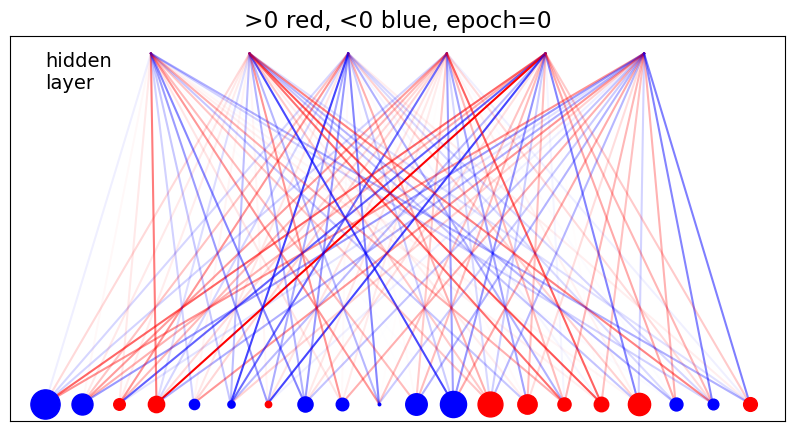

In [4]:
def create_coord(np,x0,f=1.0):
    x=[x0] * np
    print(x)
    y=list(range(np))
    for i in range(np):
        y[i] = f*(y[i]/(np-1.) - 0.5)
    return (x,y)
(x1,y1)=create_coord(L,0)
(x2,y2)=create_coord(M,1,f=0.7)

def mycolor(val):
    if val>0: return 'red'
    elif val<0: return 'blue'
    else: return 'black'

def plotgraph_vert(epoch=0):
    A=2./w.max()
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]),(y1[i],y2[j]),mycolor(w[i][j])
            plt.plot(ex, ey, col, zorder=1, lw=A*abs(w[i][j]))
            
    # Scatter plot on top of lines
    
    A=300./(a.max()+b.max())
    
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))

    for j in range(M):
        plt.scatter(x2[j], y2[j], s=A*abs(b[j]), zorder=2, c=mycolor(b[j]), marker="s")
    plt.figaspect(1)
    plt.title(f'>0 red, <0 blue, epoch={epoch}')
    plt.show()
    
def plotgraph(epoch=0):
    fig, ax = plt.subplots(1,1 , figsize=(10, 5))
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    
    A=1./max(w.max(),-w.min())
    for i in range(L):
        for j in range(M):
            ex, ey, col = (y1[i],y2[j]),(x1[i],x2[j]),mycolor(w[i][j])
            ax.plot(ex, ey, col, zorder=1, alpha=A*abs(w[i][j]))
            
    # Scatter plot on top of lines
    #A=300./(a.max()+b.max())
    
    A=500.
    for i in range(L):
        ax.scatter(y1[i],x1[i], s=A*abs(a[i]), zorder=2, c=mycolor(a[i]))
    for j in range(M):
        ax.scatter(y2[j], x2[j], s=min(300,A*abs(b[j])), zorder=2, c=mycolor(b[j]), marker="s")
    ax.set_title(f'>0 red, <0 blue, epoch={epoch}')
    ax.text(-0.5,0.9,"hidden\nlayer")
    plt.show()
                  
plotgraph()

### Activate Functions 

In [5]:
# eq(213) page 97, activation via sigmoid
# taking into account energy gap DE=2 for "spin" variables (-1,1)

def activate(v_in,wei,bias,DE,info=False):
    act = np.dot(v_in, wei) + bias
    n = np.shape(act)
    prob = 1. / (1. + exp(-DE*act))
    v_out = np.full(n, vmin, dtype=int) # a list on -1's or 0's
    v_out[np.random.random_sample(n) < prob] = 1 # activate the 1's with probability prob
    if info:
        print('input=', v_in)
        print('act=',act)
        print('prob=',prob)
        print('output=',v_out)
    return v_out

def activate_block(h,wei_block,a_block, DE): #structure perserving activate function 
                                            # Note that this function is written for Spins = False case
    
    
    thai = np.zeros(4)
        
    for j in range(len(thai)):
            
        thai[j] = np.dot(h, wei_block[j]) + a_block[j]
        
    
            
    B_gamma = np.exp(thai *  DE) # Boltzmann factor for each block structure
    
    P_gamma = B_gamma/np.sum(B_gamma)  # Compute the normalized probabilities for each block structure

    r = np.random.random()  # we generate a random number between zero and one to decide which block structure is chosen
    
    p_array = np.append([0] , np.cumsum(P_gamma)) # In this array we put the probabilities for each structure
    p = 0
    
    for i in range(len(P_gamma)):
        
        if r > p_array[i] and r < p_array[i+1]:
            
            p = i
            
    v_out = np.array([0 ,0 , 0 ,0])
    
    v_out[p] = 1
    
    return v_out

def activate_protein(h,wei,a ,  DE):  # We call the activate_block function for each block in the protein and sweep the full protein blocks to update all of the visible units 
    
    v_out = np.full(20, vmin, dtype=int)
    
    for i in range(5):
        
        v_out[i * 4:(i+1) * 4] = activate_block(h,wei[i * 4:(i+1) * 4],a[i * 4:(i+1) * 4],  DE)
        
    return v_out
    

### Energy & Partition Function Calculation

In [6]:
def energy(v_data , h_data , w , a , b ): # We calculate the energy according to the equation 205 in the review paper
                                        # note that we are unsing Bernoulli layers
    
    E = - np.dot(a , v_data) - np.dot(b , h_data) - np.dot(np.dot(v_data , w) , h_data)
    
    return E


blocks = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]  #arrays used by partiotion function
block_combs = [[v1,v2,v3,v4,v5] for v1 in blocks for v2 in blocks for v3 in blocks for v4 in blocks for v5 in blocks]
model_hs = [[h1,h2,h3,h4,h5,h6] for h1 in [0,1] for h2 in [0,1] for h3 in [0,1] for h4 in [0,1] for h5 in [0,1] for h6 in [0,1]]
model_vs = np.reshape(block_combs , (4 ** 5 , 20))


def partition(w , a , b):  # We calculate the partition function by considering all allowed combinations of visible and hidden 
    # units for one-hot coding structures. It should be noted that this function is written for spin = False case. 
    
    z = 0
    
    for v in model_vs:
        for h in model_hs:
            
            z += np.exp(-energy(v , h , w , a , b))
                
    return z

### SGD Functions

In [7]:
def ADAM(gw , ga, gb , w , a , b , t):
    
    global m_w, m_a, m_b, s_w ,s_a, s_b 
    
    if t== 1:
                
        m_w = gw 
        m_a = ga 
        m_b = gb 
                
        s_w = gw ** 2
        s_a = ga ** 2
        s_b = gb ** 2
                
    else: 
                
            # basic step of ADAM gradient descent
            
        m_w = beta1 * m_w + (1-beta1) * gw 
        m_a = beta1 * m_a + (1-beta1) * ga
        m_b = beta1 * m_b + (1-beta1) * gb
            
        s_w = beta2 * s_w + (1-beta2) * gw ** 2
        s_a = beta2 * s_a + (1-beta2) * ga ** 2
        s_b = beta2 * s_b + (1-beta2) * gb ** 2
            
            
    m_w_hat = m_w/(1 - beta1**(t))
    m_a_hat = m_a/(1 - beta1**(t))
    m_b_hat = m_b/(1 - beta1**(t))
                
    s_w_hat = s_w/(1 - beta2**(t))
    s_a_hat = s_a/(1 - beta2**(t))
    s_b_hat = s_b/(1 - beta2**(t))
                
            
    w = w + l_rate_adam * m_w_hat/(np.sqrt(s_w_hat)  + epsilon)
    a = a + l_rate_adam * m_a_hat/(np.sqrt(s_a_hat)  + epsilon)
    b = b + l_rate_adam * m_b_hat/(np.sqrt(s_b_hat)  + epsilon)
            
    return w, a, b 
        
        
def Vanila(gw , ga, gb , w , a , b):
    
    gw = gw * l_rate_vanila
    ga = ga * l_rate_vanila
    gb = gb * l_rate_vanila
    
    w = w + dw
    a = a + da
    b = b + db
    
    return w,a,b


### RBM Training

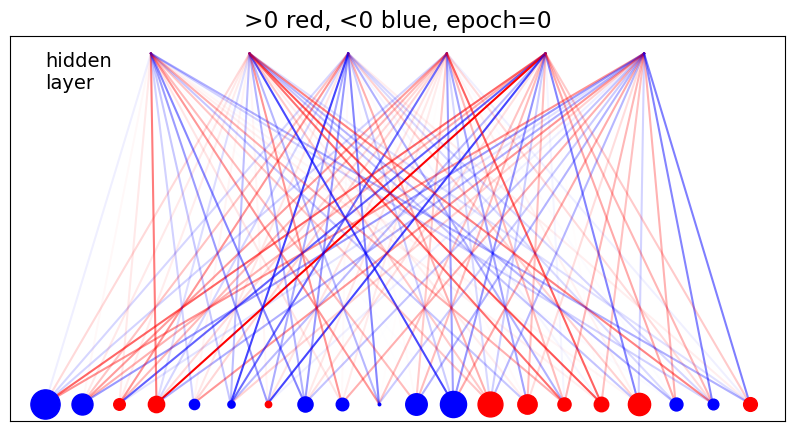

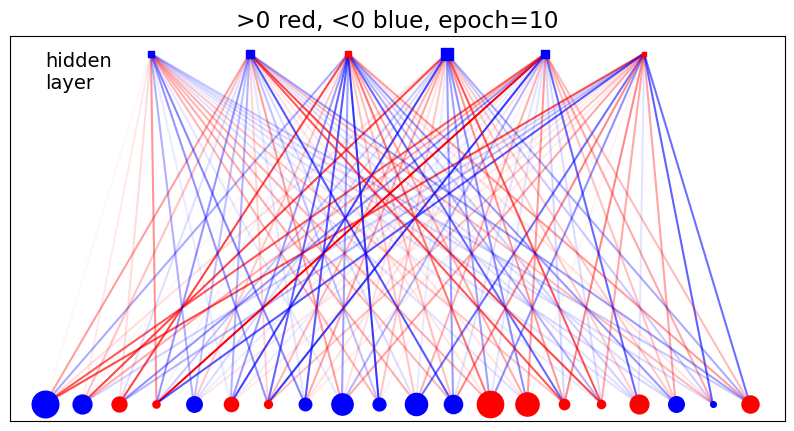

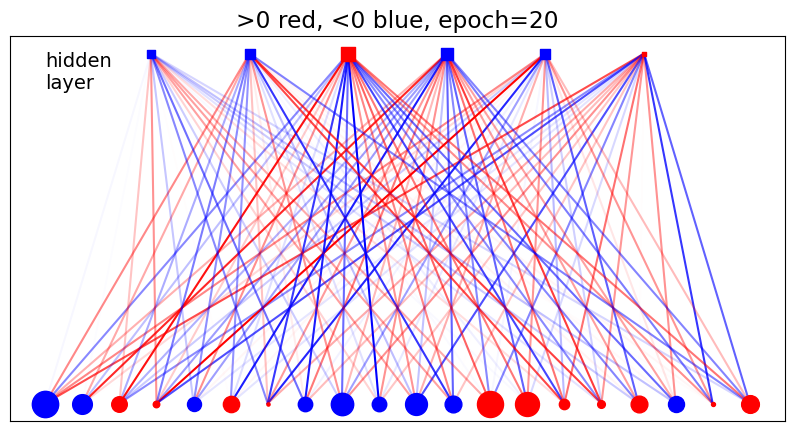

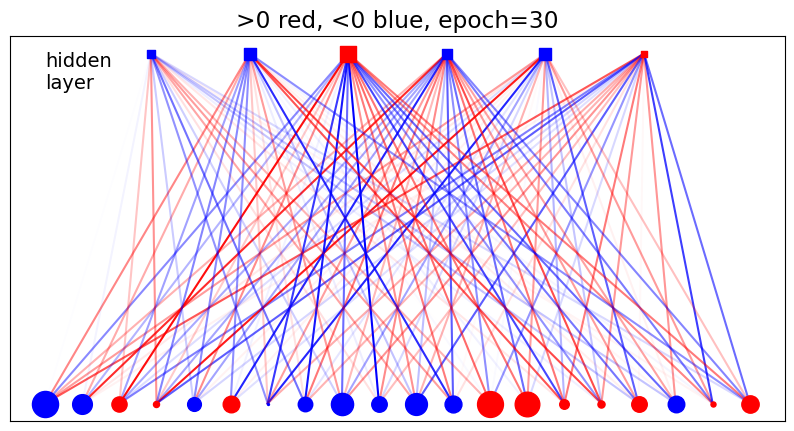

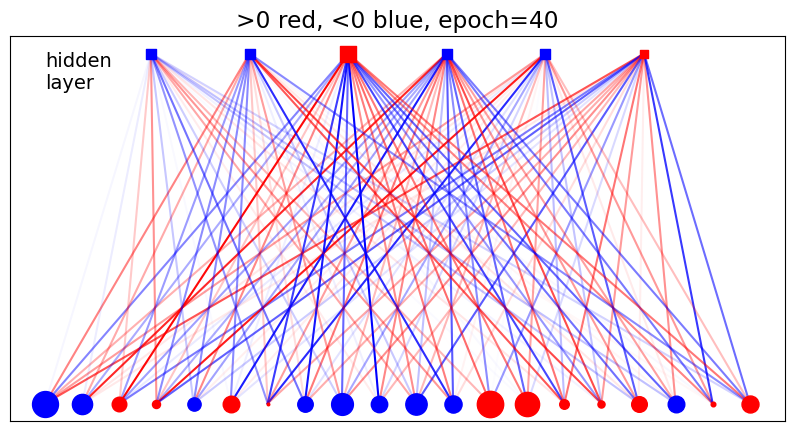

In [8]:
# random seed for reproducibility
np.random.seed(12345)
total_epochs = 40


E_list = np.zeros(total_epochs)
Z_list = np.zeros(total_epochs)


plotgraph(0)

# learning rate
l_rate_adam = 10 ** -3
l_rate_vanila = 1


#memory lifetime of the first and second moment in the ADAM SGD steps
beta1 = 0.90
beta2 = 0.99

# regularization constant
epsilon = 10 ** -8

# minibatch
mini, m = 100, 0

m_w, m_a, m_b, s_w ,s_a, s_b  = 0, 0, 0, 0, 0, 0

# train model
for epoch in range(total_epochs):
    
    

    E = 0
    t = 1  # SGD step counter
    
    for k in range(N):
        
        if m==0:
            
            # initialize averages in miniblock
            v_data, v_model = np.zeros(L),np.zeros(L)
            h_data, h_model = np.zeros(M),np.zeros(M)
            vh_data,vh_model= np.zeros((L,M)),np.zeros((L,M))
        

        # positive CD phase: generating h 
        h = activate(v[k],w,b,GAP)
        # negative CD phase: generating fantasy vf
        vf = activate_protein(h,w,a,  GAP) #block activation
        #vf = activate(h,w.T,a,GAP) #simple activation
        # one more positive CD phase: generating fantasy h from fantasy vf 
        hf = activate(vf,w,b,GAP)
        
        # second CD: generate fantasy v for the second time
        vf = activate_protein(h,w,a,  GAP)
        #vf = activate(h,w.T,a,GAP) #simple activation
        # second CD: generate fantasy h for the second time
        hf = activate(vf,w,b,GAP)
        
        # third CD: generate fantasy v for the third time
        #vf = activate_protein(h,w,a,  GAP)
        #vf = activate(h,w.T,a,GAP) #simple activation
        # third CD: generate fantasy h for the third time
        #hf = activate(vf,w,b,GAP)
        


        v_data  += v[k]
        v_model += vf
        h_data  += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model+= np.outer(vf.T,hf)
        
    
        m += 1
        # minibatch
        if m==mini:
            # gradient of the likelihood: follow it along its positive direction
            
            dw = (vh_data - vh_model) / mini
            da = (v_data - v_model) / mini
            db = (h_data - h_model) / mini
            
            w,a,b = ADAM(dw , da, db , w , a , b ,t)
            #w,a,b = Vanila(dw , da, db , w , a , b)
            
            
            m=0
            t += 1
    
    for k in range(N):
        
        h = activate(v[k],w,b,GAP)
        
        E += energy(v[k] , h , w , a , b)
        
        
    E_list[epoch] =  E/N
    Z_list[epoch] =  partition(w , a , b)
    
    
    # randomize the order of input data
    np.random.shuffle(v)
    # decrease the learning rate (here as a power law)
    
    l_rate_vanila = l_rate_vanila / (0.01 * l_rate_vanila + 1)
    
    if epoch%10==9:
        plotgraph(epoch+1)
        

### Plotting The Log-Likelihood Function over Epochs

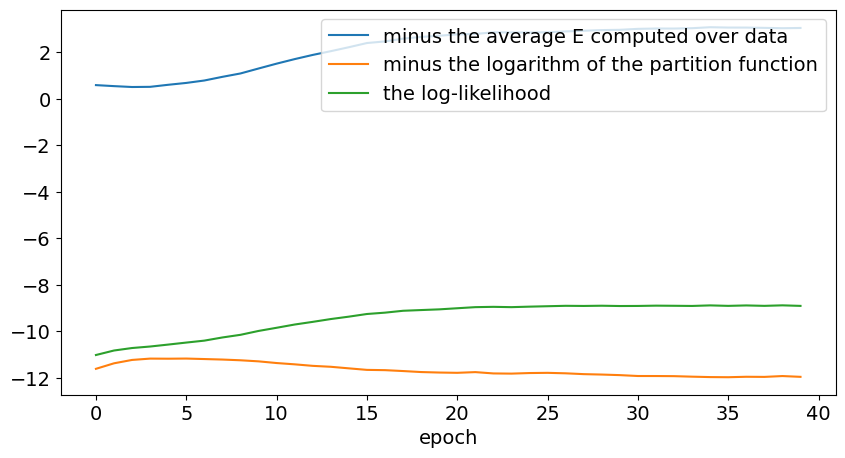

In [9]:
fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.plot(np.arange(total_epochs), -E_list , label = 'minus the average E computed over data')
ax.plot(np.arange(total_epochs), - np.log(Z_list) , label = 'minus the logarithm of the partition function')
ax.plot(np.arange(total_epochs), -E_list - np.log(Z_list) , label = 'the log-likelihood')
ax.set_xlabel('epoch')

ax.legend(loc = 'upper right')

### Results Evaluation: Schematic Comparison Between Original & Model Data

In [10]:
from IPython.display import display_html 
import pandas as pd

ampl=40.

# original, non-reshuffled data in v0
v1 = np.zeros_like(v0)
for k in range(N):
    # positive CD phase: generating h 
    h = activate(v0[k],w,b,ampl*GAP)
    # negative CD phase: generating fantasy vf with low T == large GAP
    v1[k] = activate_protein(h,w,a,ampl*GAP) #block activation
    #v1[k]= activate(h,w.T,a,ampl*GAP) #simple activation
# difference between fantasy and data
diff = (v1 - v0)/2
str0 = fname+'_M'+str(M)+'-mini'+str(mini)
np.savetxt(str0+".fantasy", (v1+1)/2, fmt='%d',delimiter=' ')  
np.savetxt(str0+'.diff', diff, fmt='%d',delimiter=' ')  


def is_one(cell_value):
    color0 = 'background-color: gray; color: white'
    color1 = 'background-color: gold;'
    if type(cell_value) in [float, int]:
        if cell_value == 1:
            return color1
    return color0

N1=20
df0 = pd.DataFrame(v0[:N1])
df1 = pd.DataFrame(((v1[:N1]-vmin)/(1-vmin)).astype(int))

df0s = df0.style.set_table_attributes("style='display:inline'")
df1s = df1.style.set_table_attributes("style='display:inline'")
df0s.applymap(is_one)
df1s.applymap(is_one)
sty = [dict(selector="caption",props=[("font-size", "150%")])]
df0s.set_caption('Original').set_table_styles(sty)
df1s.set_caption('Denoised').set_table_styles(sty)

display_html(df0s._repr_html_()+df1s._repr_html_(), raw=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
2,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0
3,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0
4,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
5,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0
6,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1
7,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0
8,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
9,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0


### Results Evaluation:  The Percentage of Deformed Rows (PDR) in Model and Original Data

In this section, we try to count the number of deformed rows (rows whose structure does not match with any of the 64 configurations allowed for rows, in the type 1 data). We use the ratio of  the deformed rows to the total rows (10000) as a criterion for evaluating the performance of our model. The less the amount of this ratio is, the better the model has performed.

In [11]:
# First We create a list of all 64 allowed configurations for visible layer in the type 1 data. 

blocks_1 = [[1,0,0,0],[0,1,0,0]] 
blocks_2 = [[0,0,1,0],[0,0,0,1]] 

block_combs_1 = [[v1,v2,v3,v4,v5] for v1 in blocks_1 for v2 in blocks_2 for v3 in blocks_1 for v4 in blocks_2 for v5 in blocks_1]
block_combs_2 = [[v1,v2,v3,v4,v5] for v1 in blocks_2 for v2 in blocks_1 for v3 in blocks_2 for v4 in blocks_1 for v5 in blocks_2]

block_combs = block_combs_1 + block_combs_2

allowed_rows = np.reshape(block_combs , (64 , 20)) # The list of allowed configurations

print("64 Allowed Configurations in Type 1 Data:")

for r in allowed_rows:
    
    print(r)

64 Allowed Configurations in Type 1 Data:
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0]
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0]
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0]
[1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0]
[1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0]
[1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0]
[1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0]
[1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0]
[1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0]
[1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0]
[1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0]
[1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0]
[1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0]
[1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0]
[1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0]
[0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0]
[0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0]
[0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0]
[0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0]
[0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0]
[0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0]
[0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1

In [12]:
# Next we count the number of rows which match with any of the allowed configurations and print out
# their ratio to the whole training data. 

counts = 0

for n in range(N):
    
    for r in allowed_rows:
        
        if (r == v1[n]).all():
            
            counts += 1
            break
            
print("percentage of deformed rows:" , (N -counts)/N * 100 , "%" )

percentage of deformed rows: 0.61 %


## Solutions to The Tasks

### Task 1

Below, you see the final result of training after 100 epochs for the data type 0. We have set spins = True:

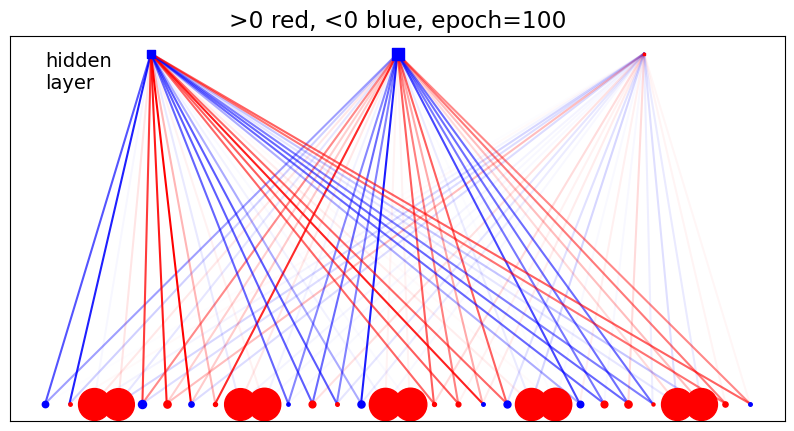

As you can see the weights corresponding to one of the hidden units are almost zero, therefore the training has automatically droped out that hidden unit. On the other hand, the local fields for the visible units in the third and fourth unit of each block, are big positive numbers (big red circles) while weights entering these units are quite small, so the results of the activation functions at these units, are almost clear: +1.

Below you can see the results for the same data, with spins = False this time:

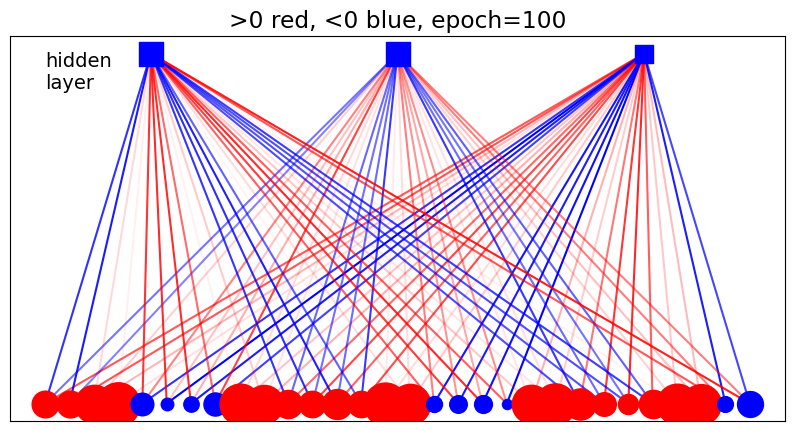

As you can see, unlike the previous case, this time all three hidden units are kept after training and moreover, it is not as easy as the previous case to guess the values of the visible units. 

So at least for data type 0 we see that setting spins = True, results in more clear results. However, we have written some of the functions in the main code, exclusively for the spin = False (See for example activate_block(...) function in the activation function part in the main code) . That is because assuming the spins = False case simplifies the computation in these functions.

### Task 2

We have implemented the ADAM SGD, in the ADAM function which you can find in the SGD Functions section in the main code. There are a couple of parameters to be tuned while using the ADAM function. 

We tested the effect of the number of samples in a mini batch, by varying them from 1 to 400 and comparing the PDR values. You can see the results in the graph below:

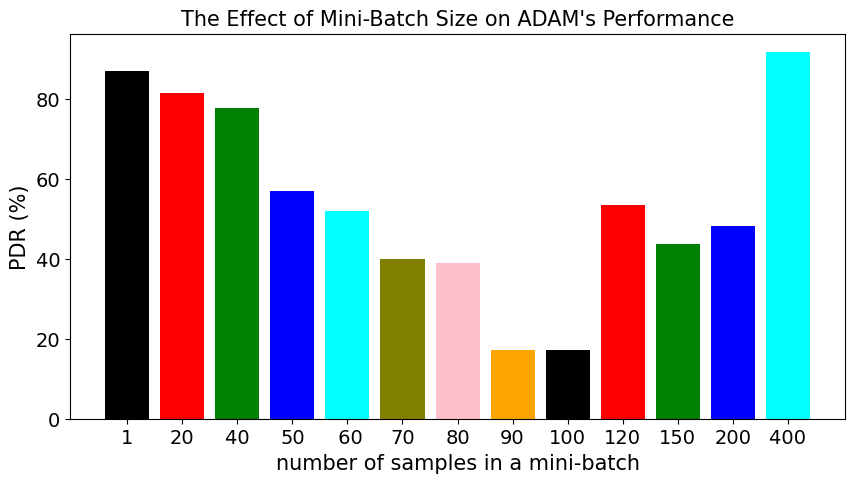

In [13]:
import matplotlib.ticker as ticker

minibatcharray = ['1','20', '40', '50',' 60','70','80' ,'90' , '100' ,'120' ,'150' , '200' ,'400']
PDR = [87,81.5, 77.78 ,56.83 ,52,40 ,39 , 17.19 , 17.19 , 53.36, 43.56 , 48.20 , 91.64]

colors = ['black', 'red', 'green', 'blue', 'cyan' , 'olive' , 'pink' , 'orange']

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.bar(range(len(PDR)), PDR , color = colors)

ax.set_title("The Effect of Mini-Batch Size on ADAM's Performance")
ax.set_xlabel('number of samples in a mini-batch')
ax.set_ylabel('PDR (%)')
#ax.set_xticklabels(minibatcharray)
ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(PDR))))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(minibatcharray))
ax.title.set_fontsize(15)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

Choosing a mini-batch size of around 100, leads to the best performance of ADAM algorithm. It appears that the energy landscape for data type 1 has many local minimas, so choosing a relatively small mini-batch helps the algorithm to jump out of local minimas by adding more randomness. 

### Task 3

We test the effect of adding more CD cycles, by again comparing the PDR of the model data produced:

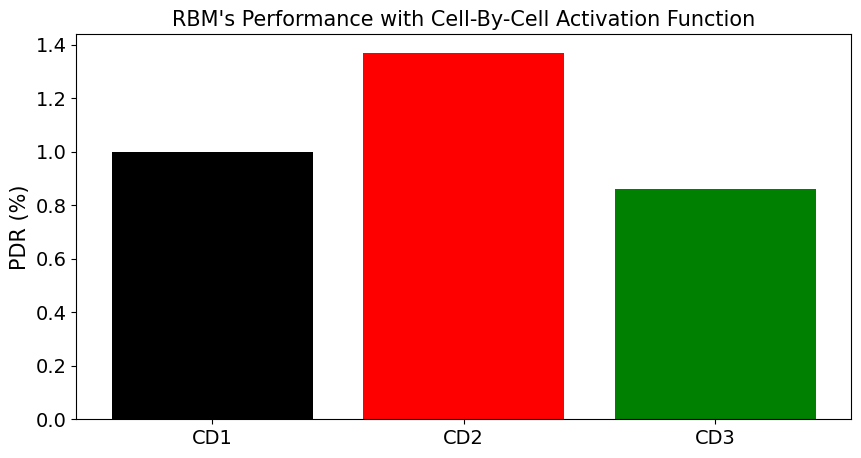

In [14]:
cdarray = ['CD1', 'CD2' , 'CD3']
PDR = [1, 1.37 , 0.86 ]

colors = ['black', 'red', 'green', 'blue', 'cyan' , 'olive' , 'pink' , 'orange']

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.bar(range(len(PDR)), PDR , color = colors)

ax.set_title("RBM's Performance with Cell-By-Cell Activation Function")
#ax.set_xlabel('number of samples in a mini-batch')
ax.set_ylabel('PDR (%)')

ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(PDR))))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(cdarray))
ax.title.set_fontsize(15)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

As you can see, applying more CD cycles has not led to meaningful different results. In fact, since we are dealing with a stochastic system, the effect of stochasticity might be more important in the above results than the effect of CD cycles. 

### Task 4

We implemented the structure perserving activation, in a function called activate_block(), defined in the activation function section of the main code. 

The best trained RBM models we achieved in the previous tasks, using the simple activate() function and choosing the optimum ADAM parameters such as the mini-batch size, had a PDR of order 1%. Using the structure perserving activation method, improves the results by 2 orders of magnitude.

Below you can see the PDR of RBM models trained with structure perserving activation, for different CD cycles:

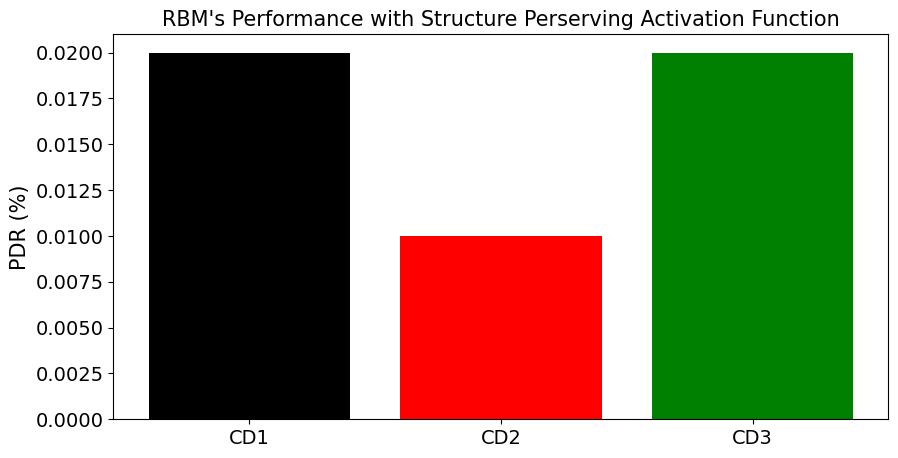

In [15]:
cdarray = ['CD1', 'CD2' , 'CD3' ]
PDR = [0.02, 0.01 , 0.02 ]

colors = ['black', 'red', 'green', 'blue', 'cyan' , 'olive' , 'pink' , 'orange']

fig, ax = plt.subplots(1,1,figsize = (10,5))

ax.bar(range(len(PDR)), PDR , color = colors)

ax.set_title("RBM's Performance with Structure Perserving Activation Function")
#ax.set_xlabel('number of samples in a mini-batch')
ax.set_ylabel('PDR (%)')

ax.xaxis.set_major_locator(ticker.FixedLocator(range(len(PDR))))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(cdarray))
ax.title.set_fontsize(15)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)

### Task 5: Optional

Below you can find the piece of code used for obtaining the desired tables:

Text(0.5, 1.0, 'Group 3')

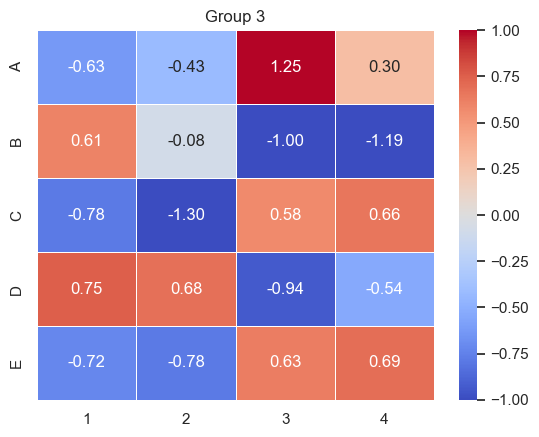

In [16]:
import pandas as pd
import seaborn as sns

w3 = np.reshape(w[:,2] , (5,4))
df = pd.DataFrame(w3, index = ['A', 'B','C','D','E'] , columns = [1,2,3,4])
sns.set(font_scale=1)
ax = sns.heatmap(df, cmap='coolwarm', vmin=-1, vmax=1, annot=True, linewidths=0.5, fmt=".2f")
ax.set_title("Group 3")

Below you can see the tables corresponding to data type = 0:

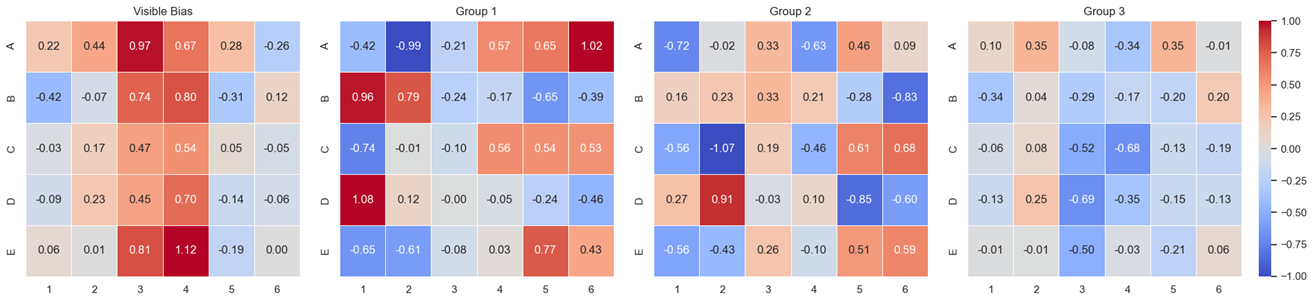

### Task 6: Optional

The energy() and partition() functions defined in section Energy and Partition of the main code, give us the tool to track the changes of the log-liklihood function over the epochs. Below you can see an example of the graph requested in this task:

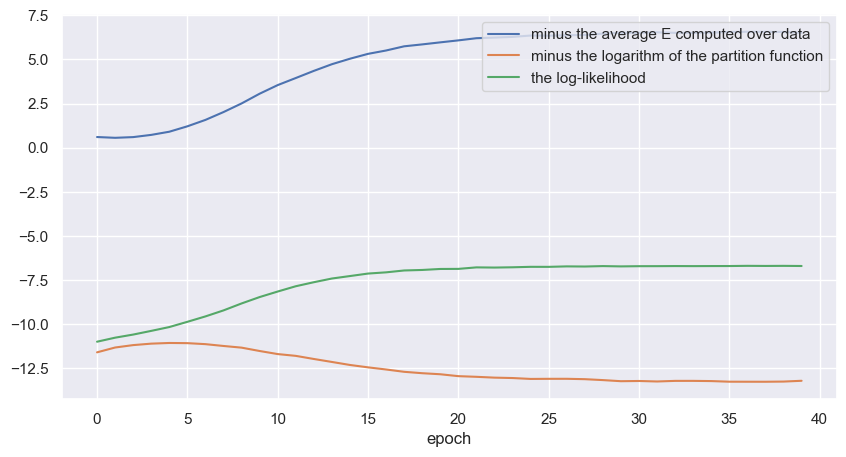

As expected, we can see that the log-liklihood function has reached to its maximum and remains flat for the rest of the epochs. 

### Additional Task For the Assignment

We were curious how the model performs when we feed it with data affected by different noises. We vary the noise probability in the notebook for generating data from q = 0.1 to q = 0.9. Then we compare the PDR value of the fantasy data and the original data. Tjis way we can test the resilience of the model against noise.

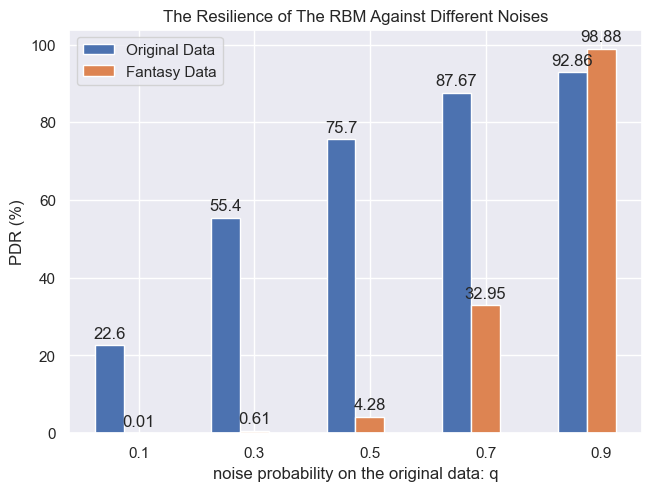

In [17]:
species = ("0.1","0.3", "0.5","0.7", "0.9")
penguin_means = {
    'Original Data': (22.6,55.40, 75.70,87.67, 92.86),
    'Fantasy Data': (0.01,0.61, 4.28,32.95, 98.88),
    
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('PDR (%)')
ax.set_xlabel('noise probability on the original data: q')

ax.set_title('The Resilience of The RBM Against Different Noises')

ax.set_xticks(x + width, species)
ax.legend(loc='upper left')
#ax.set_ylim(0, 250)

plt.show()

We observe that even at high noise probabilities as q = 0.7, our model is capable of reducing the PDR value.